In [2]:
# Setup and Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found using the .keys() method
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement  
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Analyze what columns exist in each table
inspector = inspect(engine)

#for loop to print each column name; using the get_columns method 

measurement_columns = inspector.get_columns('measurement')
print("Measurement")
for each_column in measurement_columns:
    print(each_column['name'], each_column["type"])
    
station_columns = inspector.get_columns('station')
print("\nStations")  #\n to insert a line in between results
for each_column in station_columns:
    print(each_column['name'], each_column["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f"The last date of the database is: {last_date[0]}")

# Calculate the date 1 year ago from the last data point in the database
last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"The date from one year ago is: {last_year_date}")


The last date of the database is: 2017-08-23
The date from one year ago is: 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
measurement_columns = (Measurement.date, Measurement.prcp)

precipitation_data = session.query(*measurement_columns).\
            filter(Measurement.date >= last_year_date).all()
precipitation_data[:5]    #:5 means to only give us the first 5 results 

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data,columns=['date','precipitation'])
precipitation_df.head() #display the dataframe using the .head() method available to pandas

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [15]:
# Set the index to the date column and sort the dataframe by date
precipitation_df.set_index('date',inplace=True)  #using the set_index method available to pandas 
precipitation_df = precipitation_df.sort_index()
precipitation_df  #view the dataframe

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


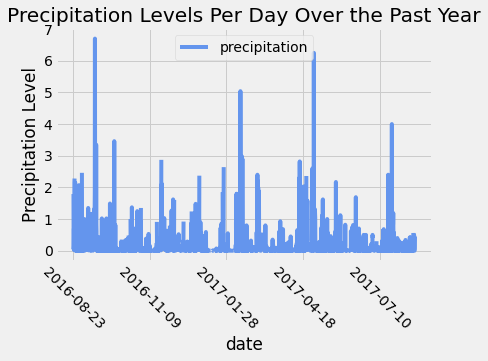

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=-45, color='cornflowerblue')
plt.title("Precipitation Levels Per Day Over the Past Year")
plt.ylabel("Precipitation Level")
plt.grid  #enable gridlines
plt.savefig ("Images/Precipatation_Barchart.png")  #save the produced figure in the images folder

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()  #use the .describe() for summary stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset
station_count = session.query(func.count(Station.id)).all()  #func.count available to sqlalchemy
station_count

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_by_station =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()   #.desc for descending order
count_by_station  #display the results to find that USC00519281 is the most active station 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()  #.all() to view all the results associated with filtered station

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
USC00519281_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > last_year_date).all()
USC00519281_data[:5]


[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

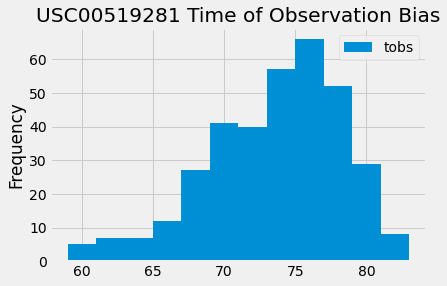

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_df= pd.DataFrame(USC00519281_data)
USC00519281_df.plot(kind="hist", bins=12, title= "USC00519281 Time of Observation Bias")  #set bins=12 as found within the instructions
plt.savefig ("Images/TOBS_Histogram.png")  #save the produced figure in the images folder